In [ ]:
#Install required modules
!pip install transformers
!pip install emoji==0.6.0
!pip install langchain
!pip install openai
!pip install chromadb tiktoken
!pip install spaCy

  Using cached emoji-0.6.0-py3-none-any.whl
  Using cached langchain-0.0.345-py3-none-any.whl (2.0 MB)


### Importing the libraries:
We import the required libraries.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import re
import string

In [ ]:
#Download the required modules
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Loading the dataset:
We use the pandas library to load the csv dataset.

In [ ]:
df = pd.read_csv('tweets.csv', encoding='latin-1', header=None)
data = df[0:25000].copy()

### Initial Dataframe:

In [ ]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data.tail()

,0,1,2,3,4,5
49995,0,1678337109,Sat May 02 06:22:31 PDT 2009,NO_QUERY,Jessica_567,@mileycyrus so i have the same insomnia prob a...
49996,0,1678337116,Sat May 02 06:22:31 PDT 2009,NO_QUERY,whouwit077,20 mintues late for my meeting starting @ 8 h...
49997,0,1678337128,Sat May 02 06:22:31 PDT 2009,NO_QUERY,AmyPR,@kentucky_derby super excited! Are you tweetin...
49998,0,1678337159,Sat May 02 06:22:32 PDT 2009,NO_QUERY,cynthia_sue03,I WANT ANOTHER DAY OFF!!!! To much Sh#t to do...
49999,0,1678337793,Sat May 02 06:22:40 PDT 2009,NO_QUERY,msceo8,i just jacked up this umbrella cake


### Pre-processing steps:

The columns' names for this dataset are not clear, so to fix it, we change the columns' names.

In [ ]:
#Setting the column names
data.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'tweet']

In [ ]:
#Dropping columns we don't need
data = data.drop(columns= ['sentiment', 'id', 'date', 'flag'])

In [ ]:
#Dropping a user who just spams the same tweet
data = data[data['user'] != 'tweetpet']

Dataframe after dropping the unnecessary columns and spammer:

In [ ]:
data.head()

,user,tweet
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,scotthamilton,is upset that he can't update his Facebook by ...
2,mattycus,@Kenichan I dived many times for the ball. Man...
3,ElleCTF,my whole body feels itchy and like its on fire
4,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#Checking for null values
data.isnull().sum()

user     0
tweet    0
dtype: int64

This indicates that there are no null values in the columns of our dataframe.

### About the dataframe:

In [ ]:
# Displaying shape
print('Shape of Data Frame:', data.shape)

Shape of Data Frame: (49690, 2)


In [ ]:
#Information about the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49690 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    49690 non-null  object
 1   tweet   49690 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Displaying descriptive statistics:

In [ ]:
data.describe(include='all')

,user,tweet
count,49690,49690
unique,41581,49459
top,sebby_peek,back to work
freq,41,8


In [ ]:
# Perform Sentiment Analysis on our dataframe from a pre-trained model in the Hugging Face library
from transformers import pipeline

model_name = "finiteautomata/bertweet-base-sentiment-analysis"

# Set up the inference pipeline using a model from the Hugging face Hub
sentiment_analysis = pipeline('sentiment-analysis', model=model_name)

# Extract tweets
tweets = data['tweet'].tolist()

# Perform sentiment analysis
sentiments = sentiment_analysis(tweets)

# Add sentiment score to each tweet
tweet_sentiments = [(tweet, sentiment['label'], sentiment['score']) for tweet, sentiment in zip(tweets, sentiments)]

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

In [ ]:
# Make the tweet, sentiment label and sentiment scores into a dataframe
data1 = pd.DataFrame(tweet_sentiments, columns=['tweet', 'label', 'score'])

In [ ]:
# Merging the DataFrames on the 'tweet' column
df1 = pd.merge(data, data1, on='tweet', how='inner')
df1.head()

,user,tweet,label,score
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",NEU,0.733360
1,scotthamilton,is upset that he can't update his Facebook by ...,NEG,0.976025
2,mattycus,@Kenichan I dived many times for the ball. Man...,NEU,0.917795
3,ElleCTF,my whole body feels itchy and like its on fire,NEG,0.936410
4,Karoli,"@nationwideclass no, it's not behaving at all....",NEG,0.975451


Pre-Processing the text to perform some visualizations tounderstand the data:

In [ ]:
def preprocess_text(text):
    # Lowercase the tweet text
    text = text.lower()

    # Remove URLs from the tweet text
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove mentions from the tweet text
    text = re.sub(r'@[A-Za-z0-9]+', '', text)

    # Remove hashtags from the tweet text
    text = re.sub(r'#', '', text)

    # Remove punctuation from the tweet text
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stop words from the tweet text
    stop_words = set(stopwords.words('english'))

    # Tokenizing and filtering the tweet text
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]

    # Lemmatize the tweet text
    lemmatizer = WordNetLemmatizer()
    lemma_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Join the words back into a single string and return
    return ' '.join(lemma_text)

In [ ]:
# Keep the pre-processed tweets in a separate column
df1['clean_tweet'] = df1['tweet'].apply(preprocess_text)

# Specify the new order of the columns as a list
new_column_order = ['user', 'tweet', 'clean_tweet', 'label', 'score']

# Rearrange the DataFrame columns
df1 = df1[new_column_order]

### Cleansed Dataframe:
After performing pre-processing, and sentiment analysis this is our cleansed dataframe:

In [ ]:
df1.head()

,user,tweet,clean_tweet,label,score
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...,NEU,0.733360
1,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,NEG,0.976025
2,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...,NEU,0.917795
3,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,NEG,0.936410
4,Karoli,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see,NEG,0.975451


In [ ]:
df1.tail()

,user,tweet,clean_tweet,label,score
50425,Jessica_567,@mileycyrus so i have the same insomnia prob a...,insomnia prob slept 3 hr woke 5am nd couldnt g...,POS,0.733452
50426,whouwit077,20 mintues late for my meeting starting @ 8 h...,20 mintues late meeting starting 8 howd know g...,POS,0.540013
50427,AmyPR,@kentucky_derby super excited! Are you tweetin...,derby super excited tweeting event happening w...,POS,0.991851
50428,cynthia_sue03,I WANT ANOTHER DAY OFF!!!! To much Sh#t to do...,want another day much sht today got quotnewuse...,NEG,0.873676
50429,msceo8,i just jacked up this umbrella cake,jacked umbrella cake,NEG,0.857193


### Visualizations:

### Count plot of sentiment:

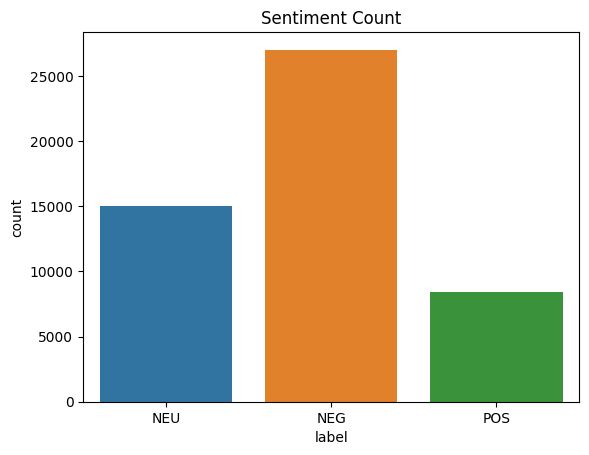

In [ ]:
sns.countplot(x='label', data=df1)
plt.title('Sentiment Count')
plt.show()

We can see that there are tweets with different sentiment labels.

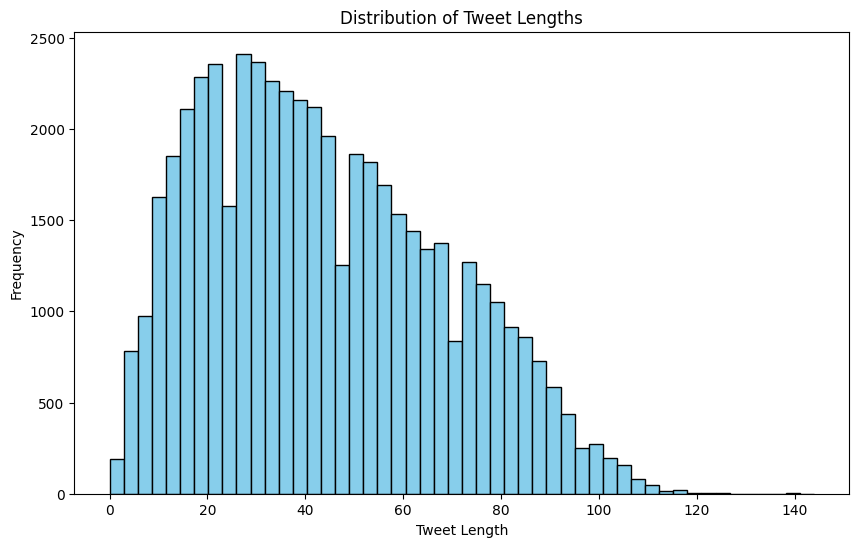

Average Tweet Length: 43.80 characters


In [ ]:
# Function to calculate the average length of tweets
def average_tweet_length(tweets):
    tweet_lengths = [len(tweet) for tweet in tweets]
    return np.mean(tweet_lengths)

# Function to plot the distribution of tweet lengths
def plot_tweet_length_distribution(tweets):
    tweet_lengths = [len(tweet) for tweet in tweets]
    plt.figure(figsize=(10, 6))
    plt.hist(tweet_lengths, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Tweet Lengths')
    plt.xlabel('Tweet Length')
    plt.ylabel('Frequency')
    plt.show()

plot_tweet_length_distribution(df1['clean_tweet'])

# Code to calculate average Tweet length
avg_length = average_tweet_length(df1['clean_tweet'])
print(f"Average Tweet Length: {avg_length:.2f} characters")


Finding the most common Bi-grams and Tri-grams:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Function to get common n-grams
def get_top_ngrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:10]  # Return top 10 n-grams

# Get top bi-grams and tri-grams
bi_grams = get_top_ngrams(df1['clean_tweet'], 2)
tri_grams = get_top_ngrams(df1['clean_tweet'], 3)

# Print top bi-grams and tri-grams
print("Top Bi-grams:", bi_grams)
print("Top Tri-grams:", tri_grams)

Top Bi-grams: [('gon na', 707), ('wan na', 706), ('last night', 543), ('want go', 395), ('feel like', 375), ('dont want', 351), ('back work', 345), ('got ta', 342), ('dont know', 333), ('go back', 327)]
Top Tri-grams: [('wan na go', 227), ('im gon na', 175), ('dont wan na', 165), ('im lonely keep', 134), ('lonely keep company', 134), ('keep company 22', 134), ('company 22 female', 134), ('dont want go', 110), ('back school tomorrow', 84), ('want go back', 81)]


In [ ]:
# Load spaCy model
import spacy
from nltk import FreqDist
from nltk.tokenize import word_tokenize

nlp = spacy.load("en_core_web_sm")

Function to extract keywords and named entities (if any):

In [ ]:
def extract_keywords(text):
    tokens = word_tokenize(text)
    fdist = FreqDist(tokens)
    keywords = [word for word, freq in fdist.most_common(5)]  # Adjust the number of keywords as needed
    return ', '.join(keywords)

# Function to extract named entities using spaCy
def extract_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return ', '.join(entities)

# Apply the functions to create new columns
df1['keywords'] = df1['clean_tweet'].apply(extract_keywords)
df1['Named_Entities'] = df1['clean_tweet'].apply(extract_named_entities)

In [ ]:
# Display the updated DataFrame with Keywords and Named Entities
df1.head()

,user,tweet,clean_tweet,label,score,keywords,Named_Entities
0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...,NEU,0.733360,"awww, thats, bummer, shoulda, got","awww, david carr, third day"
1,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...,NEG,0.976025,"upset, cant, update, facebook, texting",today
2,mattycus,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...,NEU,0.917795,"dived, many, time, ball, managed",50
3,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,NEG,0.936410,"whole, body, feel, itchy, like",
4,Karoli,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see,NEG,0.975451,"behaving, im, mad, cant, see",


People who are more active and who generally have a positive sentiment towards something have a higher chance of clicking on an any advertisement related to that something.

In [ ]:
# Group by 'user' and count tweets, then sort and select top 10
top_users = df1.groupby('user').size().sort_values(ascending=False).head(10)

# Filter the original DataFrame to keep only rows with the top 10 users
top_users_df = df1[df1['user'].isin(top_users.index)]

# Separate positive and negative sentiment tweets
positive_tweets = top_users_df[top_users_df["label"] == 'POS']
negative_tweets = top_users_df[top_users_df["label"] == 'NEG']
neutral_tweets = top_users_df[top_users_df["label"] == 'NEU']

# Print the top 10 most active users with more positive sentiment tweets
print("Top 10 most active users with more positive sentiment tweets:")
print(positive_tweets['user'].value_counts().head(10))

# Print the top 10 most active users with more negative sentiment tweets
print("\nTop 10 most active users with more negative sentiment tweets:")
print(negative_tweets['user'].value_counts().head(10))

Top 10 most active users with more positive sentiment tweets:
sebby_peek        19
Hollywood_Trey     8
amazingphoebe      7
TimmyGrunt         7
Dogbook            4
nuttychris         3
TessMorris         2
amysav83           1
Name: user, dtype: int64

Top 10 most active users with more negative sentiment tweets:
nuttychris        24
Dogbook           13
amazingphoebe     13
TessMorris        10
sebby_peek        10
amysav83           8
Hollywood_Trey     7
nessie111          5
Name: user, dtype: int64


Finding out the general sentiment distribution for the most active users:

In [ ]:
# Group by 'user' and count tweets
tweet_counts = df1.groupby('user').size()

# Sort the counts and get the top 20 users
top_20_users = tweet_counts.sort_values(ascending=False).head(20)

# Filter the original DataFrame to keep only rows with the top 20 users
top_20_df = df1[df1['user'].isin(top_20_users.index)]

# Now top_20_df contains all rows for the top 20 users with all original columns
top_20_df.head()

,user,tweet,clean_tweet,label,score,keywords,Named_Entities
98,Dogbook,Strider is a sick little puppy http://apps.fa...,strider sick little puppy,NEG,0.975850,"strider, sick, little, puppy",
109,Dogbook,Emily will be glad when Mommy is done training...,emily glad mommy done training new job miss,POS,0.979196,"emily, glad, mommy, done, training",
172,Hollywood_Trey,@naughtyhaughty I had on my page for sooooo lo...,page sooooo long got deleted sad day history,NEG,0.969146,"page, sooooo, long, got, deleted","page sooooo, sad day"
241,Augustina22CA,"im lonely keep me company! 22 female, california",im lonely keep company 22 female california,NEU,0.785218,"im, lonely, keep, company, 22","22, california"
242,Augustina22CA,"im lonely keep me company! 22 female, california",im lonely keep company 22 female california,NEU,0.785218,"im, lonely, keep, company, 22","22, california"


In [ ]:
# Function to get tweets of a specific user and write to a text file
def write_tweets_to_file(username, df1):
    # Filter the DataFrame for the given username
    user_tweets = df1[df1['user'] == username]['tweet']

    # Concatenate tweets into a single paragraph
    tweets_paragraph = '. '.join(user_tweets) + '.'

    # Writing to a text file
    with open(f"{username}_tweets.txt", "w") as file:
        file.write(tweets_paragraph)

    print(f"Tweets of {username} written to {username}_tweets.txt")

# Input username
username = input("Enter the username: ")

# Call the function with the username and DataFrame
write_tweets_to_file(username, df1)

Enter the username: sebby_peek
Tweets of sebby_peek written to sebby_peek_tweets.txt


- The code above takes a username as input, filters the DataFrame to get all tweets from that user, concatenates them into a single paragraph with each tweet separated by a full stop, and then writes this paragraph to a text file.
- We can further use this combined tweets information of any particular user for Behaviour analysis based on whatever they tweeted on Twitter.

#Behaviour Analysis:

In [ ]:
#Setting up the environment variable OPENAI_API_KEY with our own OpenAI API key
import os
os.environ["OPENAI_API_KEY"] = 'OPENAI_API_KEY'

In [ ]:
#Import necessary libraries
import langchain
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.schema.vectorstore import VectorStore
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms.openai import OpenAI
from langchain.vectorstores.chroma import Chroma
from langchain.chains.qa_with_sources.retrieval import RetrievalQAWithSourcesChain
from langchain.schema import Document
from langchain.document_loaders import TextLoader

In [ ]:
#Initialize LangChain components
vectorstore_index_creator = VectorstoreIndexCreator(vectorstore_cls=Chroma)
openai_embeddings = OpenAIEmbeddings()
openai_llm = OpenAI(embeddings=openai_embeddings, temperature=0.7)

/usr/local/lib/python3.10/dist-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! embeddings is not default parameter.
                embeddings was transferred to model_kwargs.
                Please confirm that embeddings is what you intended.
  warnings.warn(


In [ ]:
#Importing the document to be used
filename = f"{username}_tweets.txt"

In [ ]:
filename

'sebby_peek_tweets.txt'

The above document/file contains the combined tweets of the user we want to do behaviour analysis on.

In [ ]:
#Creating a Vector Store Index
from langchain.document_loaders import TextLoader
loader = TextLoader(filename, encoding='utf8')
from langchain.indexes import VectorstoreIndexCreator

index = VectorstoreIndexCreator().from_loaders([loader])

In [ ]:
index.query("Summarize the general content of this document.", retriever_kwargs={"search_kwargs": {"filter": {"source": f"{username}_tweets.txt"}}})

" This document is a conversation between two people, @amazingphoebe and another person, discussing their relationship. They talk about things that have happened between them, such as @amazingphoebe jumping off a trampoline and spraining her ankle, and the other person's suspicions and insecurities. They also talk about plans for the future, such as going out for breakfast with grandma and doing something the next day."

In [ ]:
#Implementation of RAG
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA

#RAG - Data Ingestion

#Load the document, split it into chunks, embed each chunk and load it into the vector store.
raw_documents = TextLoader(f"{username}_tweets.txt").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
documents = text_splitter.split_documents(raw_documents)
db = Chroma.from_documents(documents, OpenAIEmbeddings())

#RAG - Query

#Create a chain and use it to answer questions
qa = RetrievalQA.from_chain_type(llm=OpenAI(), chain_type="stuff", retriever=db.as_retriever())

#Question
query = "Based on the text, if I want to show them any advertisements, what will they be such that they will click on it?"
qa.run(query)

" I don't know."

In [ ]:
#Follow up Question
qa.run("Give me the behaviour analysis of the person based on the text")

' The person seems to be very loving and caring towards Phoebe. They are willing to check their emails and skype in order to stay in contact with her. They also express love and concern for her, and are willing to do anything to make her happy. However, they also seem to be very suspicious and get annoyed for no apparent reason. They also seem to struggle with self-esteem issues, as they are quick to call themselves "stupid, fucked up, retarded" in comparison to Phoebe.'

Code to get the user names who have a higher likelihood of clicking on our required brand advertisements if we show it to them. Using this information we can send our particular brand ads to only those individuals.

In [ ]:
# Define our custom input
custom_input = input("Enter your brand name here: ")

# Use regular expression to search for the keyword as a standalone word
pattern = r'\b{}\b'.format(re.escape(custom_input))

# Filter rows where 'Keyword' column contains the custom input and 'label' is 'POS'
filtered_df = df1[(df1['keywords'].str.contains(pattern, case=False, na=False)) & (df1['label'] == 'POS')]

# Print the filtered DataFrame
filtered_df

Enter your brand name here: google


,user,tweet,clean_tweet,label,score,keywords,Named_Entities
2313,crouchy,just enabled ActiveSync on my Google Apps acco...,enabled activesync google apps account sync co...,POS,0.703910,"enabled, activesync, google, apps, account",google apps
23907,Tablaman,#Google takes questions via #iPhone. Very Cool...,google take question via iphone cool app avail...,POS,0.966235,"google, take, question, via, iphone",google
37233,JBnVFCLover786,@clrzqstn yeah I searched google and went on t...,yeah searched google went one site look promis...,POS,0.743221,"yeah, searched, google, went, one",one
47015,marce17,"@Alysmiley hahaha google chrome &lt;3 , im ver...",hahaha google chrome lt3 im tired love u love ...,POS,0.983263,"google, chrome, love, hahaha, lt3",hahaha google chrome
